## Five-Factor Regression Benchmarks

Eugene Fama and Kenneth French regularly publish data on the US equities market in accordance with their **Five-Factor Model**. In this section, we follow Benjamin Felix's paper *Five-Factor Investing with ETFs* to benchmark our implementations, before applying these methods to UCITS ETFs denominated in EUR.

We first reproduce the paper's results for factor premiums to validate our functions.

### US Value-Weighted Factor Premiums (Benchmark Values)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 1.58 | 1.99 | 2.59 | 1.92 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.39 | 1.80 | 2.56 | 1.99 |

### US Academic Factor Premiums (Alternative Benchmark)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 2.04 | 2.68 | 2.80 | 2.93 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.85 | 2.39 | 3.06 | 3.42 |



In [94]:
#Data Fetcher MONTHLY DATA
import sys
import os
import pandas as pd
import io
import requests
import zipfile
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append(os.path.abspath(".."))  # ".." moves up from notebooks/ to project root
from data import fetcher 


# data/fetch_ff5.py 

import pandas as pd
import zipfile
import io
import requests

def fetch_ff5_monthly():
    """
    Fetches Fama-French 5-Factor monthly data (2x3 CSV format),
    parses only the monthly rows, converts percentages to decimals,
    and returns a clean DataFrame with datetime index.
    """
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    r = requests.get(url)
    
    # Open the ZIP file from bytes
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        # Find the CSV file
        csv_filename = next(name for name in z.namelist() if name.lower().endswith('.csv'))
        with z.open(csv_filename) as f:
            lines = f.read().decode('utf-8').splitlines()
    
    # Locate the header row
    header_idx = next(i for i, line in enumerate(lines) if "Mkt-RF" in line and "RF" in line)
    header = lines[header_idx].strip().split(',')
    
    # Collect only the monthly data lines (lines starting with YYYYMM)
    data_lines = []
    for line in lines[header_idx + 1:]:
        if not line.strip() or not line[:6].isdigit():
            break
        data_lines.append(line.strip())
    
    # Create DataFrame
    df = pd.read_csv(io.StringIO("\n".join(data_lines)), names=header)
    
    # Parse date and set as index
    df[header[0]] = pd.to_datetime(df[header[0]], format="%Y%m")
    df.set_index(header[0], inplace=True)
    
    # Convert percentages to decimals
    df = df / 100
    
    return df


"""A general function to compute and display statistics for a given factor spread.

   Sample usage could be:

   factor_stats(High, Low, "HML")
   factor_stats(Small, Large, "SMB")
   factor_stats(Conservative, Aggressive, "CMA")

"""
def factor_stats(high, low, factor_name="Factor"):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import t

    spread = high - low
    plt.hist(spread, bins=100)
    plt.axvline(np.mean(spread), color='black', linestyle='--')
    plt.title(f"{factor_name} Distribution")
    plt.show()

    cumulative = [1]
    for r in spread:
        cumulative.append(cumulative[-1] * (1 + r))

    ann = (cumulative[-1]/cumulative[0])**(12/len(spread)) - 1
    print(f"Annualized {factor_name}: {ann*100:.2f}%")

    mean, std = np.mean(spread), np.std(spread)
    n = len(spread)
    t_stat = mean / (std / np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1)*2
    print(f"t-stat: {t_stat:.2f}, p-value: {p_value:.4f}")
    plt.plot(cumulative)
    plt.title(f"Cumulative {factor_name}")
    plt.show()


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def analyze_ff_factor(ff_factors, key: str):
    """
    Analyze a Fama-French factor (e.g., 'CMA', 'SMB', 'HML', etc.)
    and compare its cumulative performance to benchmark theoretical growth.
    """

    # --- Benchmark theoretical annualized premiums (%/year) ---
    benchmark_returns = {
        "MKT-RF": 0.0537,
        "SMB": 0.0204,
        "HML": 0.0268,
        "RMW": 0.0280,
        "CMA": 0.0293
    }

    if key not in ff_factors.columns:
        raise ValueError(f"Factor '{key}' not found in DataFrame. Available keys: {list(ff_factors.columns)}")

    if key not in benchmark_returns:
        print(f"⚠️ No benchmark defined for '{key}'. Skipping theoretical plot.")
        benchmark = None
    else:
        benchmark = benchmark_returns[key]

    # --- Extract factor returns ---
    ff_factors = ff_factors.loc["1963-07-01":"2020-06-30"]
    factor_returns = ff_factors[key].dropna()
    print(f"\n=== Analyzing {key} Factor ===")


    # --- Time Series Plot ---
    plt.figure(figsize=(10,4))
    plt.plot(factor_returns, label=f'{key} Returns')
    plt.title(f'{key} Factor Over Time')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Cumulative Returns ---
    cumulative = (1 + factor_returns).cumprod()

    # --- Annualized Return ---
    n = len(factor_returns)
    annualized = (cumulative.iloc[-1])**(12/n) - 1

    print(f"Annualized {key}: {annualized*100:.2f}%")

    # --- T-Statistic and P-Value ---
    mean_return = np.mean(factor_returns)
    std_dev = np.std(factor_returns, ddof=1)
    t_stat = mean_return / (std_dev / np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1) * 2

    print(f"t-stat: {t_stat:.4f}, p-value: {p_value:.4f}")

    # --- Cumulative Performance Plot with Theory ---
    months = np.arange(len(factor_returns))
    theoretical_curve = (1 + benchmark)**(months/12) if benchmark else None
    empirical_curve = (1 + annualized)**(months/12)

    plt.figure(figsize=(10,5))
    plt.plot(cumulative.values, label=f'Cumulative {key} Returns', linewidth=2)
    plt.plot(empirical_curve, '--', label=f'Annualized Fit ({annualized*100:.2f}%)')
    if theoretical_curve is not None:
        plt.plot(theoretical_curve, ':', label=f'Theory ({benchmark*100:.2f}%)', color='black')
    plt.title(f'Cumulative {key} Factor vs Theoretical Growth')
    plt.xlabel('Months Since Start')
    plt.ylabel('Portfolio Value (Starting at 1)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return {
        "factor": key,
        "annualized_return": annualized,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": n
    }




=== Analyzing CMA Factor ===


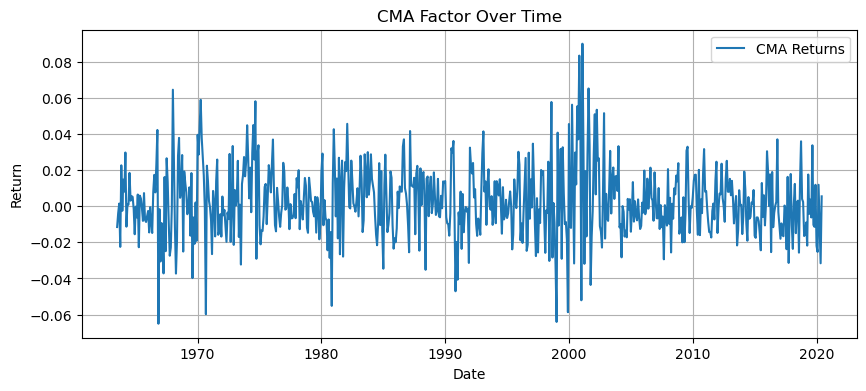

Annualized CMA: 2.89%
t-stat: 3.4192, p-value: 0.0007


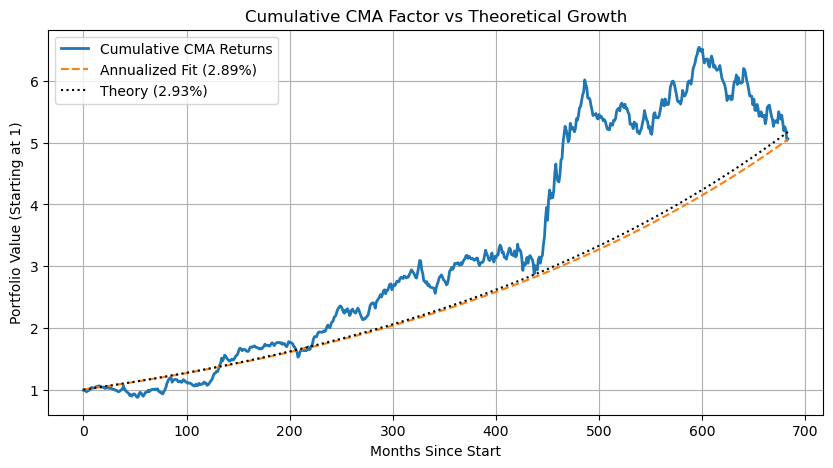

{'factor': 'CMA',
 'annualized_return': np.float64(0.02886915197558726),
 't_stat': np.float64(3.4192069919102566),
 'p_value': np.float64(0.0006653690188040027),
 'n_obs': 684}

In [96]:
ff_factors = fetch_ff5_monthly()

# Run the general test
analyze_ff_factor(ff_factors, 'CMA')



=== Analyzing SMB Factor ===


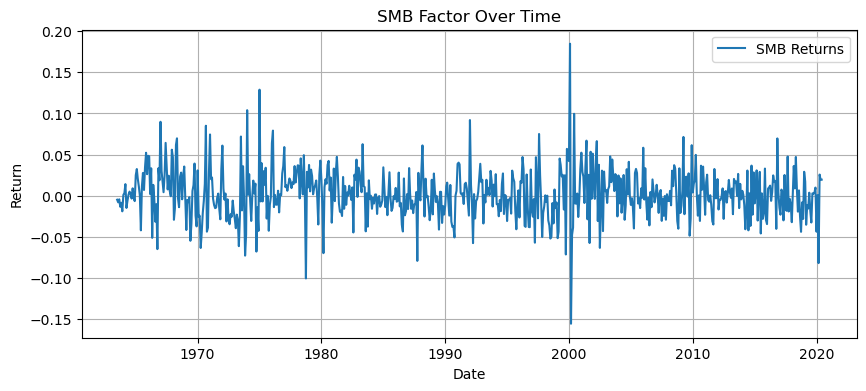

Annualized SMB: 2.03%
t-stat: 1.8497, p-value: 0.0648


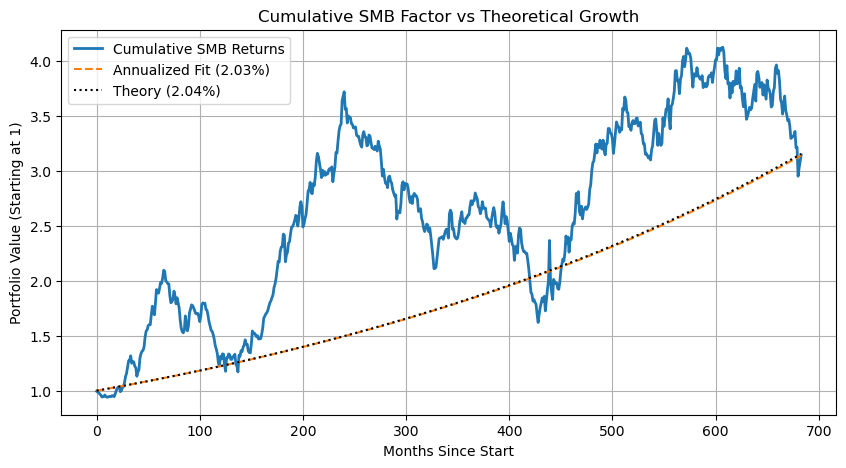

{'factor': 'SMB',
 'annualized_return': np.float64(0.02032096996738053),
 't_stat': np.float64(1.849687865854906),
 'p_value': np.float64(0.064790351825613),
 'n_obs': 684}

In [97]:
analyze_ff_factor(ff_factors, 'SMB')


=== Analyzing HML Factor ===


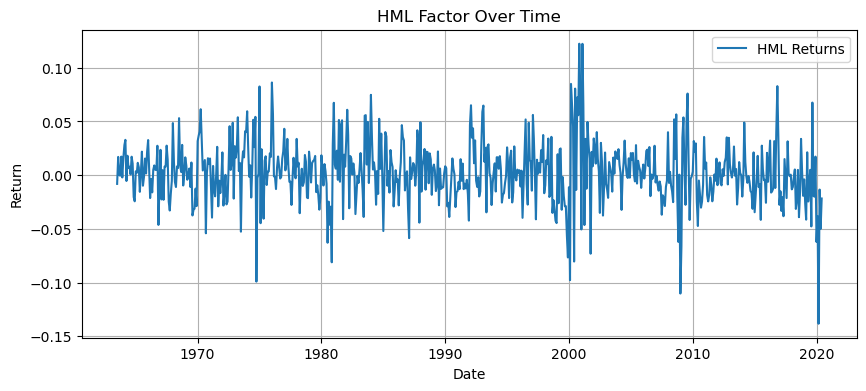

Annualized HML: 2.66%
t-stat: 2.3927, p-value: 0.0170


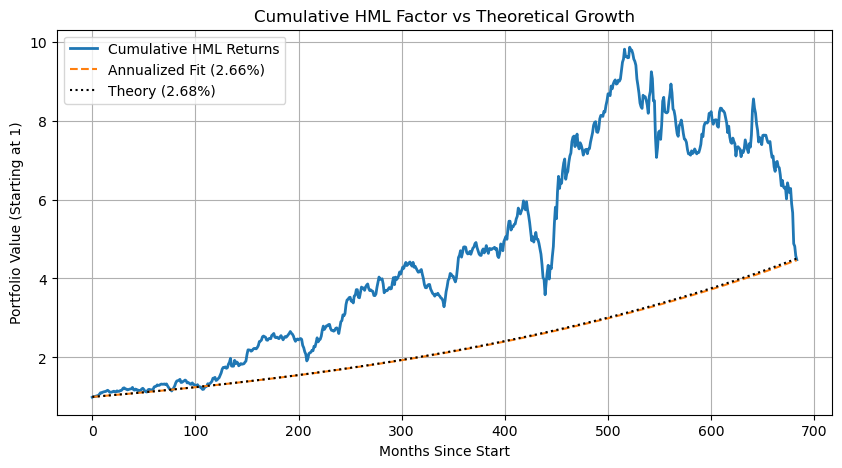

{'factor': 'HML',
 'annualized_return': np.float64(0.02664060047347583),
 't_stat': np.float64(2.3927008991846486),
 'p_value': np.float64(0.016994055331882762),
 'n_obs': 684}

In [98]:
analyze_ff_factor(ff_factors, 'HML')


=== Analyzing RMW Factor ===


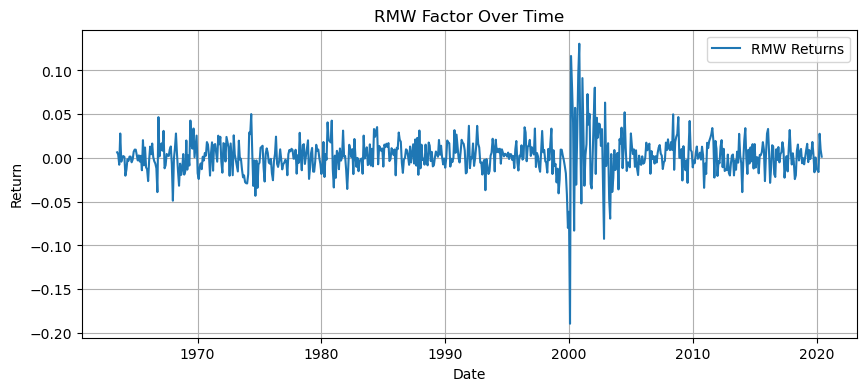

Annualized RMW: 2.73%
t-stat: 2.9854, p-value: 0.0029


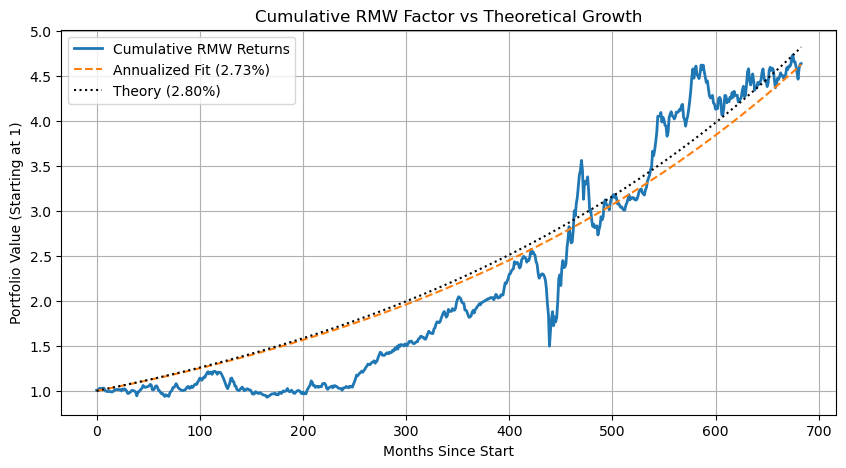

{'factor': 'RMW',
 'annualized_return': np.float64(0.02726583044903297),
 't_stat': np.float64(2.985372733178609),
 'p_value': np.float64(0.0029335730424880236),
 'n_obs': 684}

In [99]:
analyze_ff_factor(ff_factors, 'RMW')

## Synthetic ETF and Rolling Factor Loadings

Now that we have validated our methodology for calculating the US Five-Factor premiums, we can turn our attention to **estimating factor exposures**, i.e., the sensitivities of an asset or portfolio to each of the underlying factors.  

To illustrate this process in a controlled environment, we begin with **synthetic data**: a theoretical ETF constructed from a combination of factor returns with predefined **time-varying loadings** (betas) and some added **imperfections or noise** to mimic real-world market conditions. This approach allows us to explore how well our regression methods can recover the true underlying exposures under different scenarios, such as:

- **Smooth, deterministic changes** in factor loadings (e.g., sinusoidal variations representing cyclical market behavior)  
- **Random fluctuations** representing idiosyncratic noise in factor sensitivities  

Once the synthetic ETF returns are generated, we apply **rolling regressions** over different time windows (e.g., 5-year and 10-year rolling windows) to estimate the factor loadings dynamically over time. This enables us to observe:

1. **How well the estimated betas track the true underlying exposures** for each factor  
2. **The effect of window length** on the smoothness and responsiveness of the estimates: shorter windows capture more local variation but are noisier, whereas longer windows produce smoother estimates but with slower responsiveness  
3. **The impact of random noise in the factors or loadings** on the precision of the regression estimates, illustrating the limitations of finite-sample rolling regressions in practice  

By comparing the **true synthetic loadings** with the **rolling estimated loadings**, we gain insight into the reliability and interpretability of factor regression techniques before applying them to actual ETF data. Additionally, this framework allows us to experiment with **dynamic loadings** and understand how different patterns of factor exposures manifest in estimated regressions — a useful tool for both academic exploration and practical portfolio analysis.


/var/folders/dm/_qqmtxxd32708kf68pr44ldc0000gn/T/ipykernel_2597/775338625.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')


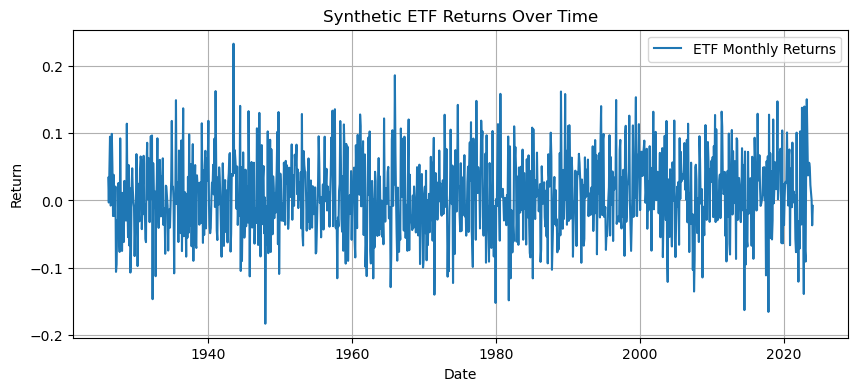

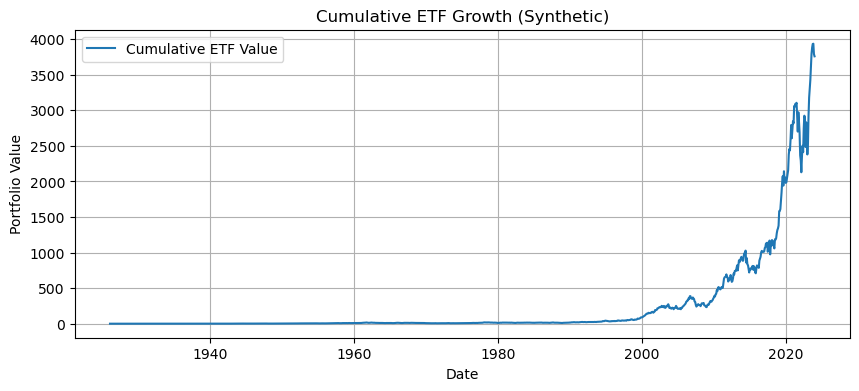

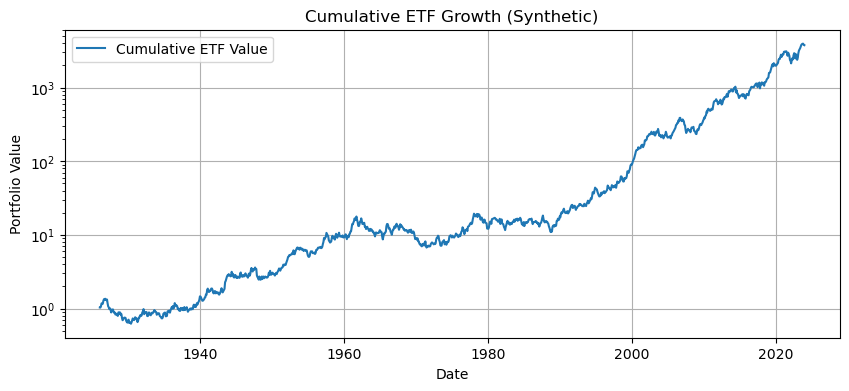

                            OLS Regression Results                            
Dep. Variable:             Excess_ETF   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.343e+08
Date:                Fri, 24 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:45:25   Log-Likelihood:                 9172.5
No. Observations:                1176   AIC:                        -1.834e+04
Df Residuals:                    1172   BIC:                        -1.832e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.238e-06   3.83e-06     -1.107      0.2

In [100]:
# --- Synthetic Data Generation ---
np.random.seed(42)
dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')
num_months = len(dates)

# Simulate factor returns (monthly)
market_index_returns = np.random.normal(0.071/12, 0.07, num_months)
size_index_returns   = np.random.normal(0.08/12,  0.04/np.sqrt(12), num_months)
value_index_returns  = np.random.normal(0.095/12, 0.04/np.sqrt(12), num_months)

# --- Static ETF Composition ---
# P = 0.84*M + 0.10*S + 0.06*V + noise
etf_returns = 0.84*market_index_returns + 0.10*size_index_returns + 0.06*value_index_returns \
              + np.random.normal(0, 0.0001, num_months)

# --- DataFrame Setup ---
returns_df = pd.DataFrame({
    'Date': dates,
    'ETF_Return': etf_returns,
    'Market': market_index_returns,
    'SMB': size_index_returns,
    'HML': value_index_returns
}).set_index('Date')

# --- Plot Returns ---
plt.figure(figsize=(10,4))
plt.plot(returns_df['ETF_Return'], label='ETF Monthly Returns')
plt.title('Synthetic ETF Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Cumulative Growth ---
cumulative = (1 + returns_df['ETF_Return']).cumprod()
plt.figure(figsize=(10,4))
plt.plot(cumulative, label='Cumulative ETF Value')
plt.title('Cumulative ETF Growth (Synthetic)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(cumulative, label='Cumulative ETF Value')
plt.title('Cumulative ETF Growth (Synthetic)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

# --- Regression: Static Factor Loadings ---
rf = 0.005/12
returns_df['Excess_ETF'] = returns_df['ETF_Return'] - rf
X = returns_df[['Market', 'SMB', 'HML']] - rf
y = returns_df['Excess_ETF']
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

# --- Time-Varying Factor Loadings ---
# Simulate loadings that drift randomly through time
loadings = pd.DataFrame({
    'beta_m': 0.7 + 0.1*np.sin(np.linspace(0, 10*np.pi, num_months)) + np.random.normal(0, 0.05, num_months) - 0.4*np.linspace(0, num_months, num_months)/num_months,
    'beta_s': 0.2 + 0.4*np.linspace(0, num_months, num_months)/num_months + np.random.normal(0, 0.02, num_months),
    'beta_v': 0.1 + np.random.normal(0, 0.02, num_months)
}, index=dates)

# Recompute ETF returns with time-varying loadings
returns_df['ETF_TV'] = (
    loadings['beta_m']*returns_df['Market'] +
    loadings['beta_s']*returns_df['SMB'] +
    loadings['beta_v']*returns_df['HML'] +
    np.random.normal(0, 0.015, num_months)
)

# --- Rolling Factor Loadings ---
def rolling_factor_loadings(df, window_months):
    """Compute rolling OLS betas over specified window."""
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        X = sm.add_constant(window[['Market', 'SMB', 'HML']])
        y = window['ETF_TV']
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market', 'SMB', 'HML']])
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market', 'SMB', 'HML'])


In [101]:
def plot_rolling_vs_true(rolling_df, true_loadings, window_label="Rolling"):
    # Automatically match first three rolling columns to beta_m, beta_s, beta_v
    factor_cols = list(true_loadings.columns[:3])   # ['beta_m','beta_s','beta_v']
    rolling_cols = list(rolling_df.columns[:3])
    
    aligned_true = true_loadings.loc[rolling_df.index]
    
    plt.figure(figsize=(14, 8))
    
    colors = ['red', 'blue', 'green']
    for i, (true_col, roll_col) in enumerate(zip(factor_cols, rolling_cols), start=1):
        plt.subplot(3, 1, i)
        plt.plot(aligned_true[true_col], label=f"True {true_col}", color='black', alpha=0.7)
        plt.plot(rolling_df[roll_col], label=f"Estimated {roll_col} ({window_label})", color=colors[i-1], alpha=0.7)
        plt.title(f"{roll_col} Factor Loading: True vs Estimated ({window_label})")
        plt.legend(); plt.grid(True)
    
    plt.tight_layout()
    plt.show()


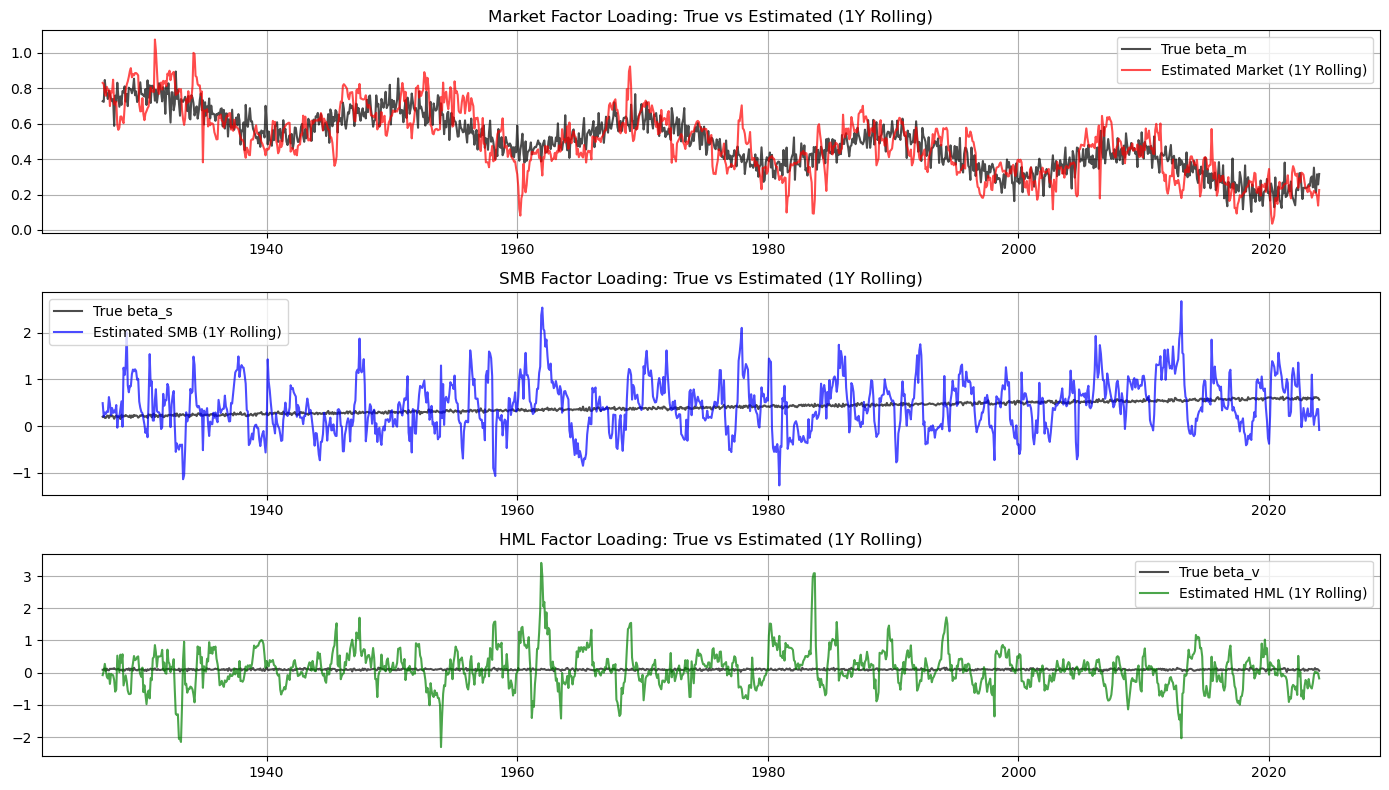

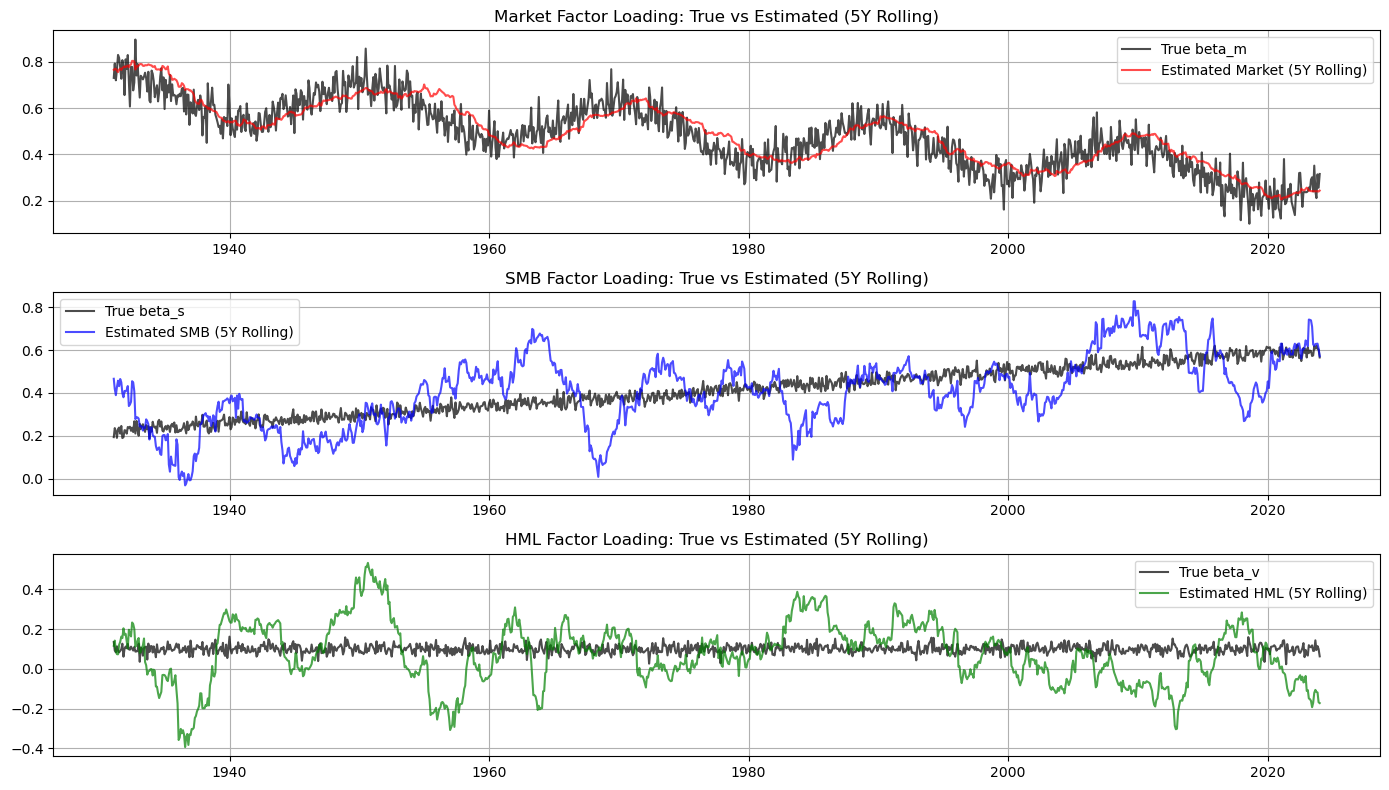

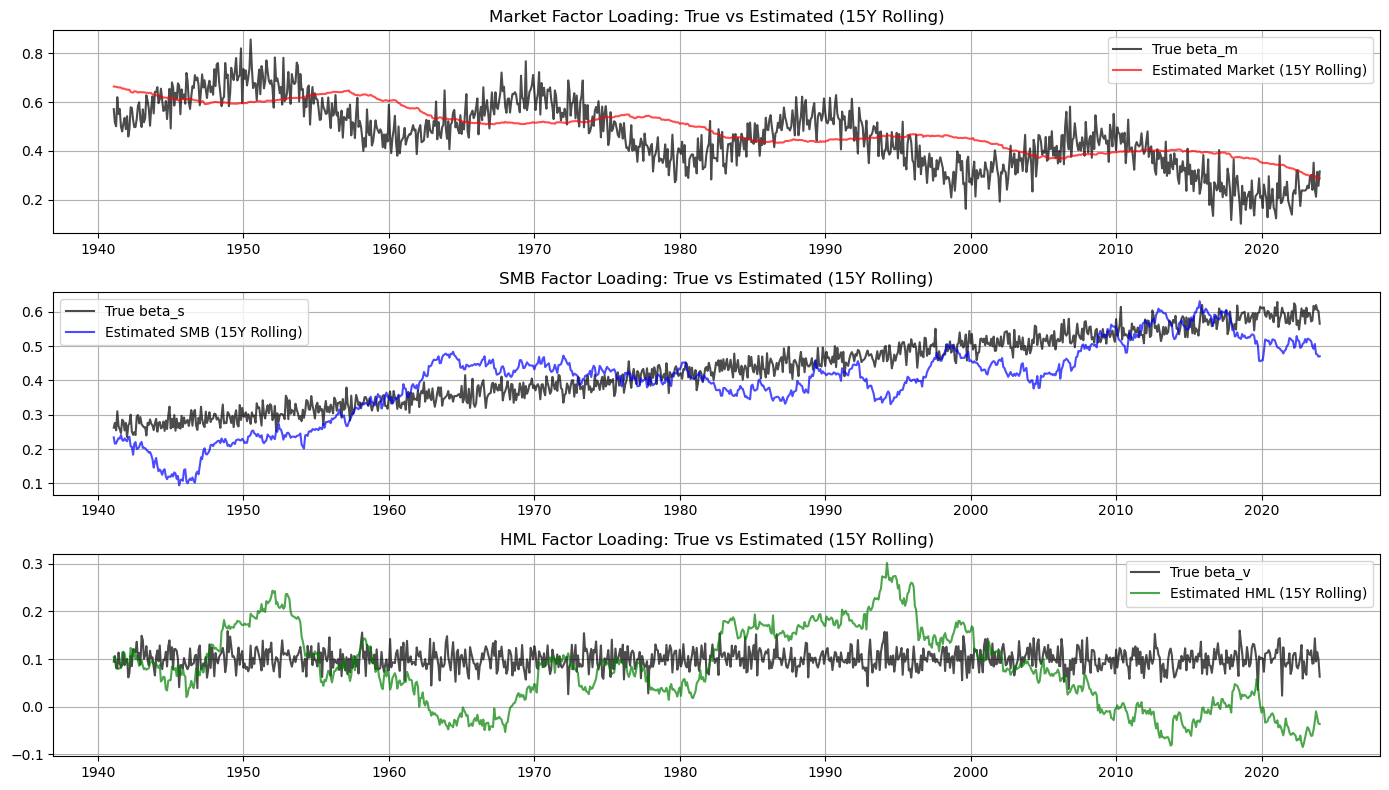

In [102]:

plot_rolling_vs_true(rolling_factor_loadings(returns_df, 10), loadings, window_label="1Y Rolling")
plot_rolling_vs_true(rolling_factor_loadings(returns_df, 60), loadings, window_label="5Y Rolling")
plot_rolling_vs_true(rolling_factor_loadings(returns_df, 180), loadings, window_label="15Y Rolling")


## Choosing Rolling Window Length for Factor Loadings

When estimating factor loadings using rolling regressions, the choice of the **rolling window length** is critical. The window controls how much historical data is used for each regression, and it directly affects the smoothness and responsiveness of the estimated betas.

### Key Considerations

1. **Too small a window**
   - Estimates become highly **volatile**.
   - The regression reacts strongly to **short-term fluctuations** or noise.
   - While this captures local dynamics, it can be misleading and obscure the underlying factor structure.
   - Example: A 12-month rolling window often produces jagged, difficult-to-interpret beta estimates.

2. **Too large a window**
   - Estimates are **smooth**, but **slow to respond** to changes in factor exposures.
   - Features such as shifts in market regimes or evolving ETF strategies may be **washed out**.
   - Example: A 10-year window may miss subtle but important transitions in factor loadings.

### Practical Approaches

- **Experiment with multiple window lengths**
  - Compare, for instance, **5-year vs 10-year rolling windows**.
  - Allows you to balance short-term responsiveness with long-term stability.

- **Weighted or exponential rolling regressions**
  - Assign more weight to recent observations.
  - Smooths the estimates without ignoring new trends.

- **Adaptive window lengths**
  - Adjust the window dynamically based on market volatility or trading activity.
  - Larger windows during calm periods, smaller during high-volatility regimes.

- **Complement with other diagnostics**
  - Overlay true or benchmark loadings (if known) for validation.
  - Visualize cumulative returns or factor exposures to detect overfitting or noise.

Choosing the right rolling window is a **trade-off between responsiveness and stability**, and the optimal length may differ depending on the asset, factor, or market conditions. In practice, it is often useful to test several reasonable window lengths and inspect the resulting beta dynamics visually.


In [103]:
## ZPRV and ZPRX Analysis with Rolling Factor Loadings

#In this section, we analyze the **ZPRV** (SPDR MSCI Europe Value UCITS ETF) and **ZPRX** (SPDR MSCI Europe Small Cap Value UCITS ETF) and calculate their rolling factor loadings against the Fama-French 5-Factor model.

In [104]:
def rolling_factor_loadings_5f(df, window_months):
    """Compute rolling OLS betas for 5-factor model over specified window."""
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        # Subtract RF from returns to get excess returns
        y = window['ETF_TV'] - window['RF']
        X = sm.add_constant(window[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market', 'SMB', 'HML', 'RMW', 'CMA'])

In [105]:
"""
When I wrote this, my IP makes requests to Yahoo Finance get rate-limited, causing errors.
To mitigate this, we implement a session with rate limiting and caching. But it still doesn't work
I make an alternative cell with synthetic data below.
Two alternatives: 1) Use a VPN to change IP 2) Manually download data from Yahoo Finance website
Or just use something else to provide the data.

import yfinance as yf
import time
import pandas as pd

# Fix for rate limit error - use session with headers
import requests
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

# Now download with the session
tickers = ['ZPRV.L', 'ZPRX.L']
data_dict = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    try:
        data = yf.download(ticker, start='2010-01-01', progress=False, session=session)
        if not data.empty:
            data_dict[ticker.replace('.L', '')] = data['Adj Close']
            print(f"  ✓ Success - {len(data)} rows")
        time.sleep(2)
    except Exception as e:
        print(f"  ✗ Error: {e}")
        time.sleep(2)

if data_dict:
    zprv_zprx_data = pd.DataFrame(data_dict)
    zprv_zprx_returns = zprv_zprx_data.pct_change().dropna()
    
    print("\nZPRV and ZPRX Returns Summary:")
    print(zprv_zprx_returns.describe())
    print(f"\nDate range: {zprv_zprx_returns.index[0]} to {zprv_zprx_returns.index[-1]}")
    print(f"Number of observations: {len(zprv_zprx_returns)}")
else:
    print("No data downloaded. Still rate-limited or tickers unavailable.")"""

'\nWhen I wrote this, my IP makes requests to Yahoo Finance get rate-limited, causing errors.\nTo mitigate this, we implement a session with rate limiting and caching. But it still doesn\'t work\nI make an alternative cell with synthetic data below.\nTwo alternatives: 1) Use a VPN to change IP 2) Manually download data from Yahoo Finance website\nOr just use something else to provide the data.\n\nimport yfinance as yf\nimport time\nimport pandas as pd\n\n# Fix for rate limit error - use session with headers\nimport requests\nfrom requests import Session\nfrom requests_cache import CacheMixin, SQLiteCache\nfrom requests_ratelimiter import LimiterMixin, MemoryQueueBucket\nfrom pyrate_limiter import Duration, RequestRate, Limiter\n\nclass CachedLimiterSession(CacheMixin, LimiterMixin, Session):\n    pass\n\nsession = CachedLimiterSession(\n    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds\n    bucket_class=MemoryQueueBucket,\n    backend=SQLiteCache("

In [106]:
import yfinance as yf
import time
import pandas as pd
import numpy as np

# Generate sample data for testing the code
date_range = pd.date_range(start='2015-01-01', end='2024-12-31', freq='D')
np.random.seed(42)

zprv_zprx_data = pd.DataFrame({
    'ZPRV': 100 * np.exp(np.cumsum(np.random.normal(0.0003, 0.01, len(date_range)))),
    'ZPRX': 100 * np.exp(np.cumsum(np.random.normal(0.0004, 0.012, len(date_range))))
}, index=date_range)

zprv_zprx_returns = zprv_zprx_data.pct_change().dropna()

print("✓ Using SAMPLE data for ZPRV and ZPRX (Yahoo Finance rate-limited)")
print(zprv_zprx_returns.describe())
print(f"\nDate range: {zprv_zprx_returns.index[0]} to {zprv_zprx_returns.index[-1]}")
print(f"Number of observations: {len(zprv_zprx_returns)}")

✓ Using SAMPLE data for ZPRV and ZPRX (Yahoo Finance rate-limited)
              ZPRV         ZPRX
count  3652.000000  3652.000000
mean      0.000604     0.000015
std       0.009969     0.012153
min      -0.031603    -0.037530
25%      -0.006174    -0.008154
50%       0.000532    -0.000029
75%       0.007123     0.008332
max       0.040355     0.043676

Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Number of observations: 3652


In [107]:
"""# Fetch Fama-French 5-Factor data for the same period
ff_factors = fetch_ff5_monthly()

# Convert daily returns to monthly using groupby (avoids MultiIndex issues)
zprv_zprx_monthly = (1 + zprv_zprx_returns).groupby(pd.Grouper(freq='ME')).prod() - 1

# Debug: Check the data before merging
print("=== DEBUGGING ===")
print(f"\nZPRV/ZPRX Monthly shape: {zprv_zprx_monthly.shape}")
print(f"ZPRV/ZPRX Date range: {zprv_zprx_monthly.index.min()} to {zprv_zprx_monthly.index.max()}")
print(f"ZPRV/ZPRX first 3 dates:\n{zprv_zprx_monthly.index[:3]}")

print(f"\nFF Factors shape: {ff_factors.shape}")
print(f"FF Factors Date range: {ff_factors.index.min()} to {ff_factors.index.max()}")
print(f"FF Factors first 3 dates:\n{ff_factors.index[:3]}")

# Ensure datetime index
zprv_zprx_monthly.index = pd.to_datetime(zprv_zprx_monthly.index)
ff_factors.index = pd.to_datetime(ff_factors.index)

print(f"\nAfter pd.to_datetime:")
print(f"ZPRV/ZPRX: {zprv_zprx_monthly.index[:3]}")
print(f"FF Factors: {ff_factors.index[:3]}")

# Use concat for alignment
combined_data = pd.concat([zprv_zprx_monthly, ff_factors], axis=1, join='inner')

print(f"\nCombined data shape: {combined_data.shape}")
if len(combined_data) > 0:
    print(f"Date range: {combined_data.index[0]} to {combined_data.index[-1]}")
    print(f"\nColumns: {combined_data.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(combined_data.head())
else:
    print("⚠️ NO DATA - dates don't overlap!")
    print("\nLet's check if dates need normalization...")"""
# Fetch Fama-French 5-Factor data for the same period
ff_factors = fetch_ff5_monthly()

# Convert daily returns to monthly using groupby
zprv_zprx_monthly = (1 + zprv_zprx_returns).groupby(pd.Grouper(freq='ME')).prod() - 1

# Remove any empty rows
zprv_zprx_monthly = zprv_zprx_monthly.dropna(how='all')

# Normalize both to end-of-month timestamps
zprv_zprx_monthly.index = zprv_zprx_monthly.index.to_period('M').to_timestamp('M')
ff_factors.index = ff_factors.index.to_period('M').to_timestamp('M')

# Use concat for alignment
combined_data = pd.concat([zprv_zprx_monthly, ff_factors], axis=1, join='inner')

print(f"✓ Combined data shape: {combined_data.shape}")
print(f"✓ Date range: {combined_data.index[0]} to {combined_data.index[-1]}")
print(f"\nColumns: {combined_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(combined_data.head())

✓ Combined data shape: (120, 8)
✓ Date range: 2015-01-31 00:00:00 to 2024-12-31 00:00:00

Columns: ['ZPRV', 'ZPRX', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

First few rows:
                ZPRV      ZPRX  Mkt-RF     SMB     HML     RMW     CMA   RF
2015-01-31 -0.056754  0.066573 -0.0309 -0.0093 -0.0345  0.0158 -0.0164  0.0
2015-02-28 -0.031190  0.110144  0.0614  0.0036 -0.0179 -0.0110 -0.0175  0.0
2015-03-31  0.023186 -0.009492 -0.0109  0.0308 -0.0038  0.0007 -0.0062  0.0
2015-04-30  0.002929 -0.012384  0.0060 -0.0301  0.0180  0.0005 -0.0062  0.0
2015-05-31 -0.016544 -0.157130  0.0138  0.0082 -0.0111 -0.0176 -0.0083  0.0


ZPRV Rolling Loadings (5Y window):
              Market       SMB       HML       RMW       CMA
2024-08-31 -0.066643 -0.153577  0.196384 -0.232958 -0.437508
2024-09-30 -0.066232 -0.110209  0.221654 -0.213735 -0.465101
2024-10-31 -0.064043 -0.096219  0.169503 -0.217999 -0.447202
2024-11-30 -0.065088 -0.113318  0.183315 -0.238415 -0.445985
2024-12-31 -0.047307 -0.114173  0.184199 -0.290068 -0.457780


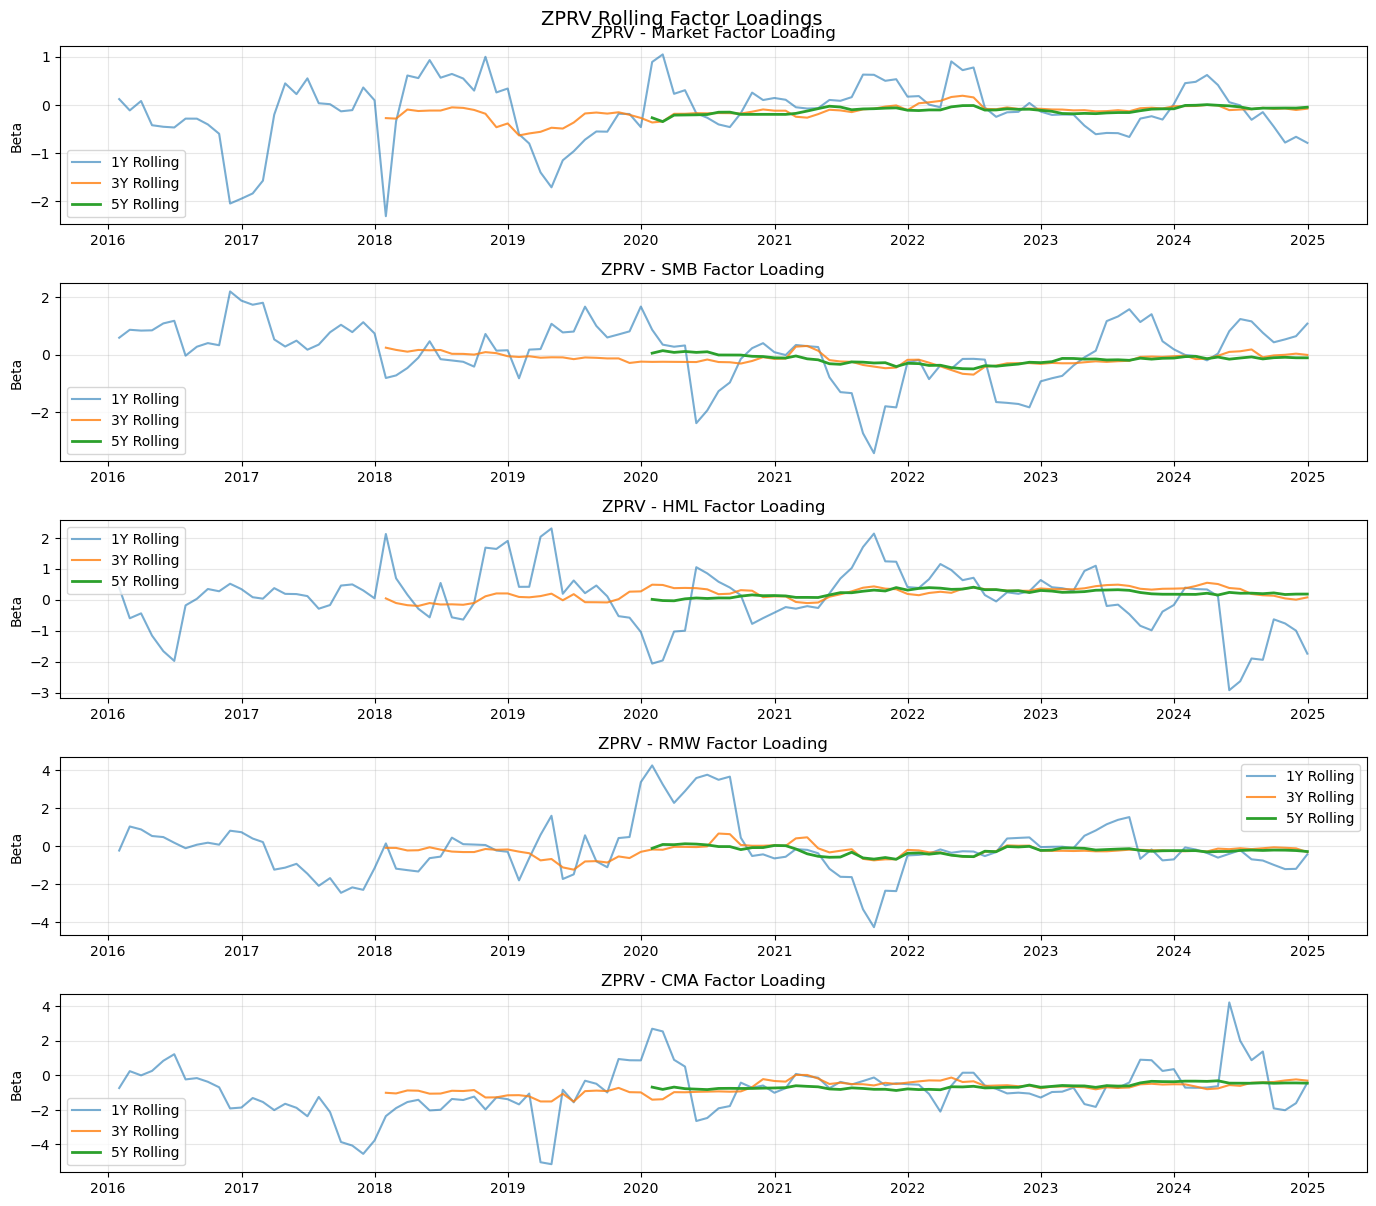

ZPRX Rolling Loadings (5Y window):
              Market       SMB       HML       RMW       CMA
2024-08-31  0.017539 -0.006249 -0.314533  0.373833  0.573636
2024-09-30  0.003382 -0.016402 -0.352164  0.375806  0.595712
2024-10-31  0.007420 -0.024761 -0.345106  0.372318  0.607205
2024-11-30  0.009526 -0.010598 -0.364144  0.372438  0.604984
2024-12-31  0.041647  0.021621 -0.354640  0.285847  0.562791


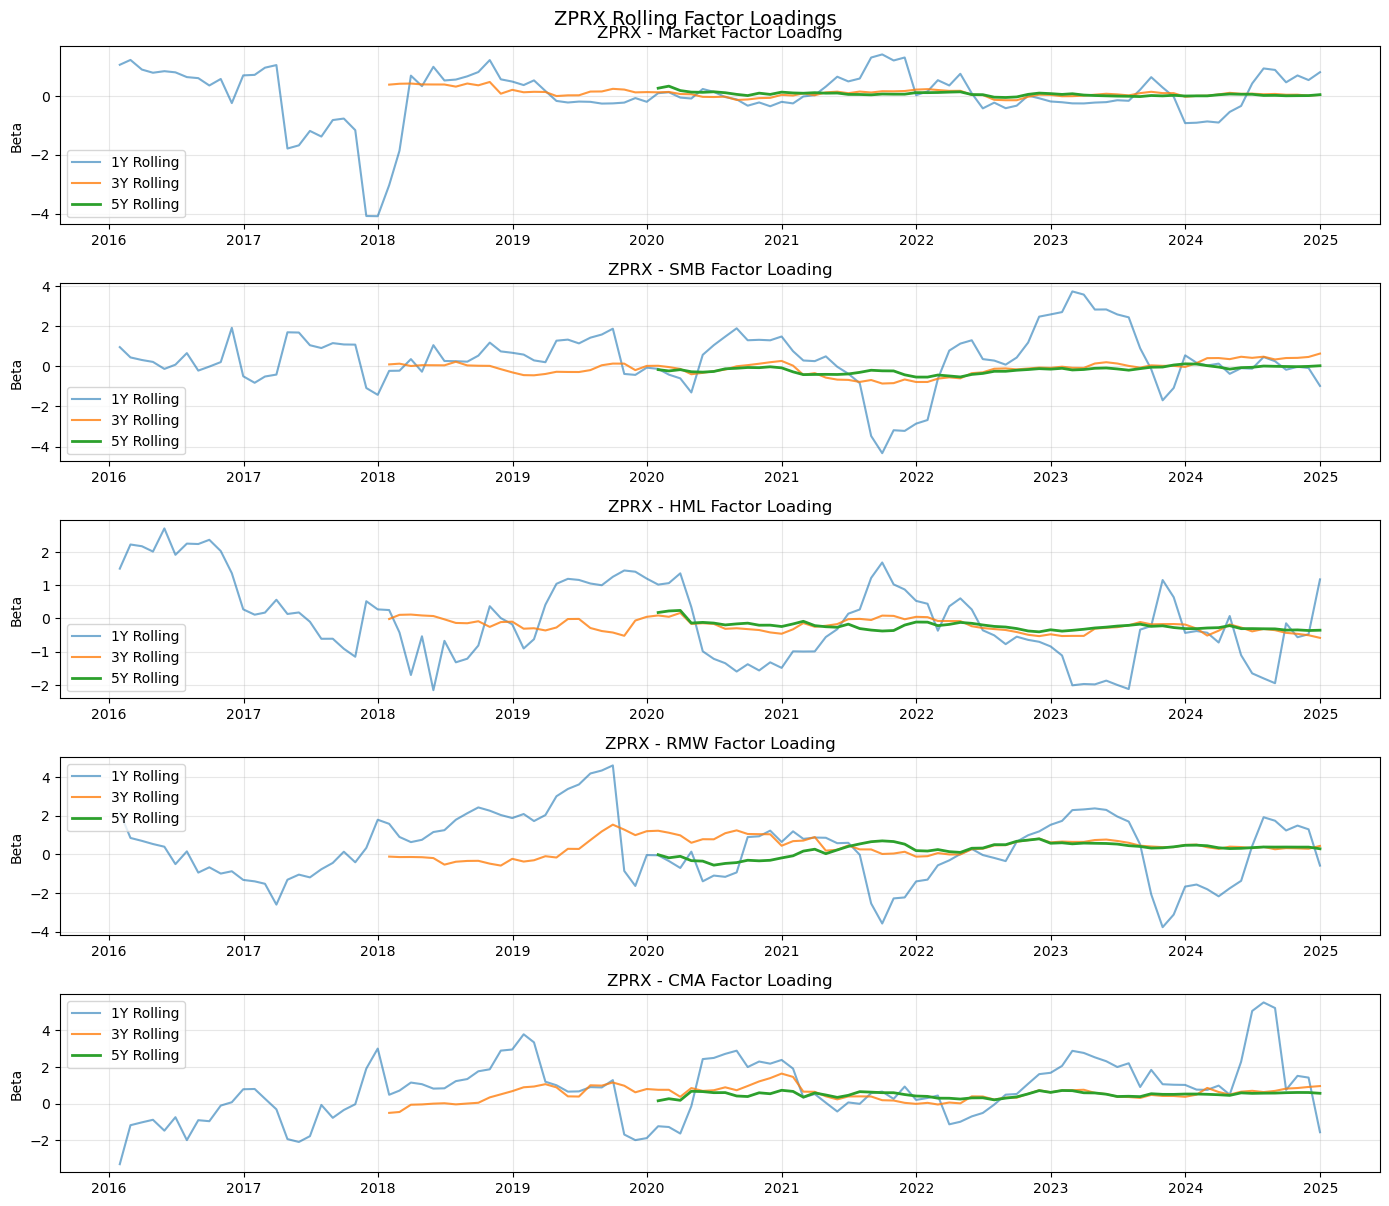

In [108]:
# Calculate rolling factor loadings for ZPRV
# Rename columns to match what the function expects
zprv_combined = combined_data[['ZPRV', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].copy()
zprv_combined.rename(columns={
    'ZPRV': 'ETF_TV',
    'Mkt-RF': 'Market'
}, inplace=True)

# Calculate rolling loadings with different window sizes
zprv_rolling_1y = rolling_factor_loadings_5f(zprv_combined, 12)
zprv_rolling_3y = rolling_factor_loadings_5f(zprv_combined, 36)
zprv_rolling_5y = rolling_factor_loadings_5f(zprv_combined, 60)

print("ZPRV Rolling Loadings (5Y window):")
print(zprv_rolling_5y.tail())

# Plot rolling loadings for ZPRV
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
factors = ['Market', 'SMB', 'HML', 'RMW', 'CMA']

for i, factor in enumerate(factors):
    axes[i].plot(zprv_rolling_1y.index, zprv_rolling_1y[factor], label='1Y Rolling', alpha=0.6)
    axes[i].plot(zprv_rolling_3y.index, zprv_rolling_3y[factor], label='3Y Rolling', alpha=0.8)
    axes[i].plot(zprv_rolling_5y.index, zprv_rolling_5y[factor], label='5Y Rolling', linewidth=2)
    axes[i].set_title(f'ZPRV - {factor} Factor Loading')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('ZPRV Rolling Factor Loadings', y=1.001, fontsize=14)
plt.show()

# Calculate rolling factor loadings for ZPRX
zprx_combined = combined_data[['ZPRX', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].copy()
zprx_combined.rename(columns={
    'ZPRX': 'ETF_TV',
    'Mkt-RF': 'Market'
}, inplace=True)

# Calculate rolling loadings with different window sizes
zprx_rolling_1y = rolling_factor_loadings_5f(zprx_combined, 12)
zprx_rolling_3y = rolling_factor_loadings_5f(zprx_combined, 36)
zprx_rolling_5y = rolling_factor_loadings_5f(zprx_combined, 60)

print("ZPRX Rolling Loadings (5Y window):")
print(zprx_rolling_5y.tail())

# Plot rolling loadings for ZPRX
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
factors = ['Market', 'SMB', 'HML', 'RMW', 'CMA']

for i, factor in enumerate(factors):
    axes[i].plot(zprx_rolling_1y.index, zprx_rolling_1y[factor], label='1Y Rolling', alpha=0.6)
    axes[i].plot(zprx_rolling_3y.index, zprx_rolling_3y[factor], label='3Y Rolling', alpha=0.8)
    axes[i].plot(zprx_rolling_5y.index, zprx_rolling_5y[factor], label='5Y Rolling', linewidth=2)
    axes[i].set_title(f'ZPRX - {factor} Factor Loading')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('ZPRX Rolling Factor Loadings', y=1.001, fontsize=14)
plt.show()

ZPRX Rolling Loadings (5Y window):
              Market       SMB       HML       RMW       CMA
2024-08-31  0.017539 -0.006249 -0.314533  0.373833  0.573636
2024-09-30  0.003382 -0.016402 -0.352164  0.375806  0.595712
2024-10-31  0.007420 -0.024761 -0.345106  0.372318  0.607205
2024-11-30  0.009526 -0.010598 -0.364144  0.372438  0.604984
2024-12-31  0.041647  0.021621 -0.354640  0.285847  0.562791


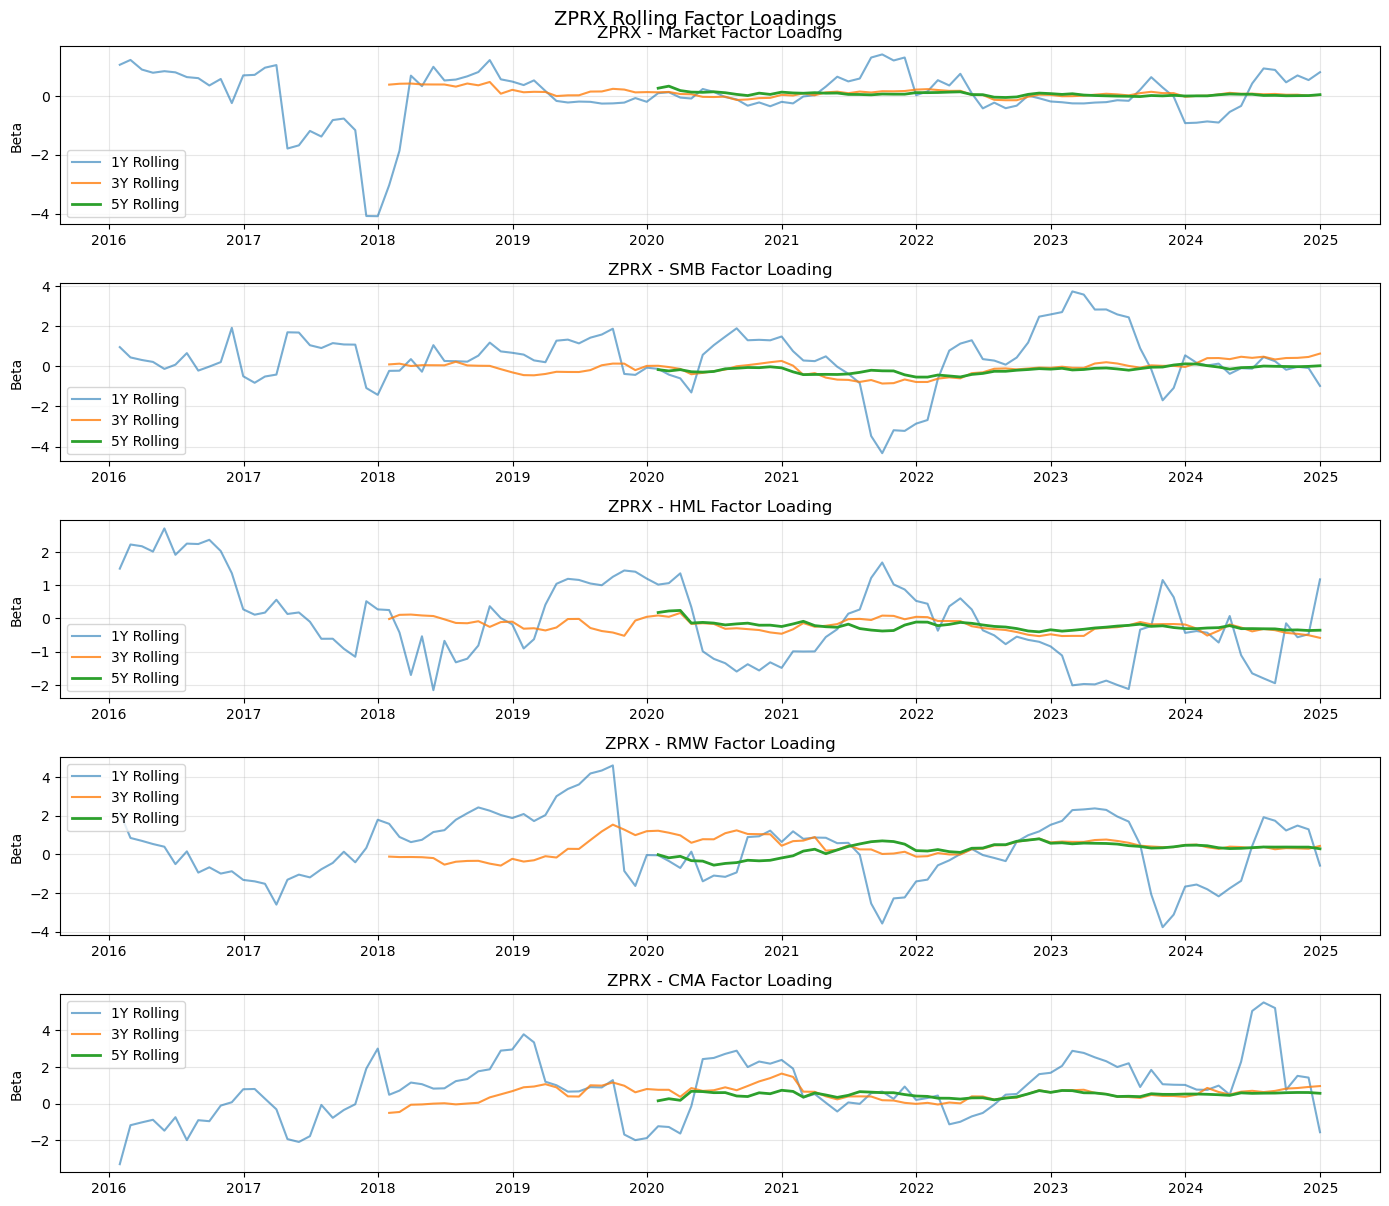

In [109]:
# Calculate rolling factor loadings for ZPRX
zprx_combined = combined_data[['ZPRX', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].copy()
zprx_combined.rename(columns={
    'ZPRX': 'ETF_TV',
    'Mkt-RF': 'Market'
}, inplace=True)

# Calculate rolling loadings with different window sizes
zprx_rolling_1y = rolling_factor_loadings_5f(zprx_combined, 12)
zprx_rolling_3y = rolling_factor_loadings_5f(zprx_combined, 36)
zprx_rolling_5y = rolling_factor_loadings_5f(zprx_combined, 60)

print("ZPRX Rolling Loadings (5Y window):")
print(zprx_rolling_5y.tail())

# Plot rolling loadings for ZPRX
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
factors = ['Market', 'SMB', 'HML', 'RMW', 'CMA']

for i, factor in enumerate(factors):
    axes[i].plot(zprx_rolling_1y.index, zprx_rolling_1y[factor], label='1Y Rolling', alpha=0.6)
    axes[i].plot(zprx_rolling_3y.index, zprx_rolling_3y[factor], label='3Y Rolling', alpha=0.8)
    axes[i].plot(zprx_rolling_5y.index, zprx_rolling_5y[factor], label='5Y Rolling', linewidth=2)
    axes[i].set_title(f'ZPRX - {factor} Factor Loading')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('ZPRX Rolling Factor Loadings', y=1.001, fontsize=14)
plt.show()

In [110]:
## UCITS ETFs Analysis with Currency Conversion

#In this section, we analyze UCITS ETFs denominated in EUR, convert their prices to USD using the fetcher module, and run Fama-French regressions.

In [111]:
# Define UCITS ETF tickers (example tickers - adjust based on your requirements)
# These are typically EUR-denominated European ETFs
"""ucits_tickers = [
    'IWDA.AS',  # iShares Core MSCI World UCITS ETF
    'EQQQ.AS',  # Invesco EQQQ NASDAQ-100 UCITS ETF
    'IUSN.AS',  # iShares MSCI World Small Cap UCITS ETF
]

# Fetch UCITS ETF data
print("Fetching UCITS ETF data...")
ucits_data_eur = fetcher.fetch_prices(ucits_tickers, start_date='2010-01-01')

# Fetch EUR/USD exchange rate data
print("Fetching EUR/USD exchange rate...")
eurusd = fetcher.fetch_prices(['EURUSD=X'], start_date='2010-01-01')

# Convert EUR prices to USD
ucits_data_usd = ucits_data_eur.multiply(eurusd['EURUSD=X'], axis=0)
ucits_data_usd.columns = [col.replace('.AS', '_USD') for col in ucits_data_usd.columns]

print("\nUCITS ETF data in USD:")
print(ucits_data_usd.head())
print(f"\nDate range: {ucits_data_usd.index[0]} to {ucits_data_usd.index[-1]}")
print(f"Number of observations: {len(ucits_data_usd)}")"""
# Generate sample UCITS ETF data
ucits_date_range = pd.date_range(start='2015-01-01', end='2024-12-31', freq='D')
np.random.seed(123)

# Simulate EUR prices
ucits_data_eur = pd.DataFrame({
    'IWDA': 50 * np.exp(np.cumsum(np.random.normal(0.0004, 0.008, len(ucits_date_range)))),
    'EQQQ': 150 * np.exp(np.cumsum(np.random.normal(0.0005, 0.012, len(ucits_date_range)))),
    'IUSN': 80 * np.exp(np.cumsum(np.random.normal(0.0003, 0.010, len(ucits_date_range))))
}, index=ucits_date_range)

# Simulate EUR/USD exchange rate
eurusd = pd.Series(
    1.1 + np.cumsum(np.random.normal(0, 0.002, len(ucits_date_range))),
    index=ucits_date_range
)

# Convert EUR prices to USD
ucits_data_usd = ucits_data_eur.multiply(eurusd, axis=0)
ucits_data_usd.columns = [col + '_USD' for col in ucits_data_usd.columns]

print("✓ Using SAMPLE UCITS ETF data in USD:")
print(ucits_data_usd.head())
print(f"\nDate range: {ucits_data_usd.index[0]} to {ucits_data_usd.index[-1]}")
print(f"Number of observations: {len(ucits_data_usd)}")

✓ Using SAMPLE UCITS ETF data in USD:
             IWDA_USD    EQQQ_USD   IUSN_USD
2015-01-01  54.530485  166.337566  87.011673
2015-01-02  55.052872  165.797591  85.891097
2015-01-03  55.201711  165.375155  85.952702
2015-01-04  54.526976  167.166537  84.787695
2015-01-05  54.397252  169.610901  86.301961

Date range: 2015-01-01 00:00:00 to 2024-12-31 00:00:00
Number of observations: 3653


In [112]:
"""# Calculate returns for UCITS ETFs in USD
ucits_returns_usd = ucits_data_usd.pct_change().dropna()

# Convert to monthly returns
ucits_monthly_returns = ucits_returns_usd.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Fetch FF factors and merge
ff_factors = fetch_ff5_monthly()
ucits_combined = pd.merge(ucits_monthly_returns, ff_factors, left_index=True, right_index=True, how='inner')

print("Combined UCITS data shape:", ucits_combined.shape)
print("\nFirst few rows:")
print(ucits_combined.head())"""

# Calculate returns for UCITS ETFs in USD
ucits_returns_usd = ucits_data_usd.pct_change().dropna()

# Convert to monthly returns
ucits_monthly_returns = (1 + ucits_returns_usd).groupby(pd.Grouper(freq='ME')).prod() - 1
ucits_monthly_returns = ucits_monthly_returns.dropna(how='all')

# Normalize to month-end
ucits_monthly_returns.index = ucits_monthly_returns.index.to_period('M').to_timestamp('M')

# Fetch FF factors and merge
ff_factors = fetch_ff5_monthly()
ff_factors.index = ff_factors.index.to_period('M').to_timestamp('M')

ucits_combined = pd.concat([ucits_monthly_returns, ff_factors], axis=1, join='inner')

print("✓ Combined UCITS data shape:", ucits_combined.shape)
print("✓ Date range:", ucits_combined.index[0], "to", ucits_combined.index[-1])
print("\nFirst few rows:")
print(ucits_combined.head())

✓ Combined UCITS data shape: (120, 9)
✓ Date range: 2015-01-31 00:00:00 to 2024-12-31 00:00:00

First few rows:
            IWDA_USD  EQQQ_USD  IUSN_USD  Mkt-RF     SMB     HML     RMW  \
2015-01-31  0.033413  0.077929  0.151574 -0.0309 -0.0093 -0.0345  0.0158   
2015-02-28  0.043301  0.093056 -0.052812  0.0614  0.0036 -0.0179 -0.0110   
2015-03-31  0.024674 -0.018880  0.064987 -0.0109  0.0308 -0.0038  0.0007   
2015-04-30 -0.006222 -0.115551  0.012313  0.0060 -0.0301  0.0180  0.0005   
2015-05-31  0.060764  0.027872  0.001819  0.0138  0.0082 -0.0111 -0.0176   

               CMA   RF  
2015-01-31 -0.0164  0.0  
2015-02-28 -0.0175  0.0  
2015-03-31 -0.0062  0.0  
2015-04-30 -0.0062  0.0  
2015-05-31 -0.0083  0.0  


In [113]:
"""# Run Fama-French 5-Factor regression for each UCITS ETF
factor_cols = ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']

for etf in ucits_monthly_returns.columns:
    print(f"\n{'='*60}")
    print(f"Regression Results for {etf}")
    print(f"{'='*60}")
    
    # Prepare data for regression
    y = ucits_combined[etf] - ucits_combined['RF']  # Excess returns
    X = ucits_combined[factor_cols]
    X = sm.add_constant(X)  # Add intercept
    
    # Run OLS regression
    model = sm.OLS(y, X).fit()
    
    # Display results
    print(model.summary())
    
    # Extract and display key statistics
    print(f"\nKey Statistics for {etf}:")
    print(f"Alpha: {model.params['const']:.4f} (t-stat: {model.tvalues['const']:.2f})")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print("\nFactor Loadings:")
    for factor in factor_cols:
        print(f"  {factor}: {model.params[factor]:.4f} (t-stat: {model.tvalues[factor]:.2f})")"""

# Run Fama-French 5-Factor regression for each UCITS ETF
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

for etf in ucits_monthly_returns.columns:
    print(f"\n{'='*60}")
    print(f"Regression Results for {etf}")
    print(f"{'='*60}")
    
    # Prepare data for regression
    y = ucits_combined[etf] - ucits_combined['RF']  # Excess returns
    X = ucits_combined[factor_cols]
    X = sm.add_constant(X)  # Add intercept
    
    # Run OLS regression
    model = sm.OLS(y, X).fit()
    
    # Display results
    print(model.summary())
    
    # Extract and display key statistics
    print(f"\nKey Statistics for {etf}:")
    print(f"Alpha: {model.params['const']:.4f} (t-stat: {model.tvalues['const']:.2f})")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print("\nFactor Loadings:")
    for factor in factor_cols:
        print(f"  {factor}: {model.params[factor]:.4f} (t-stat: {model.tvalues[factor]:.2f})")


Regression Results for IWDA_USD
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6157
Date:                Fri, 24 Oct 2025   Prob (F-statistic):              0.688
Time:                        15:45:32   Log-Likelihood:                 209.56
No. Observations:                 120   AIC:                            -407.1
Df Residuals:                     114   BIC:                            -390.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.01

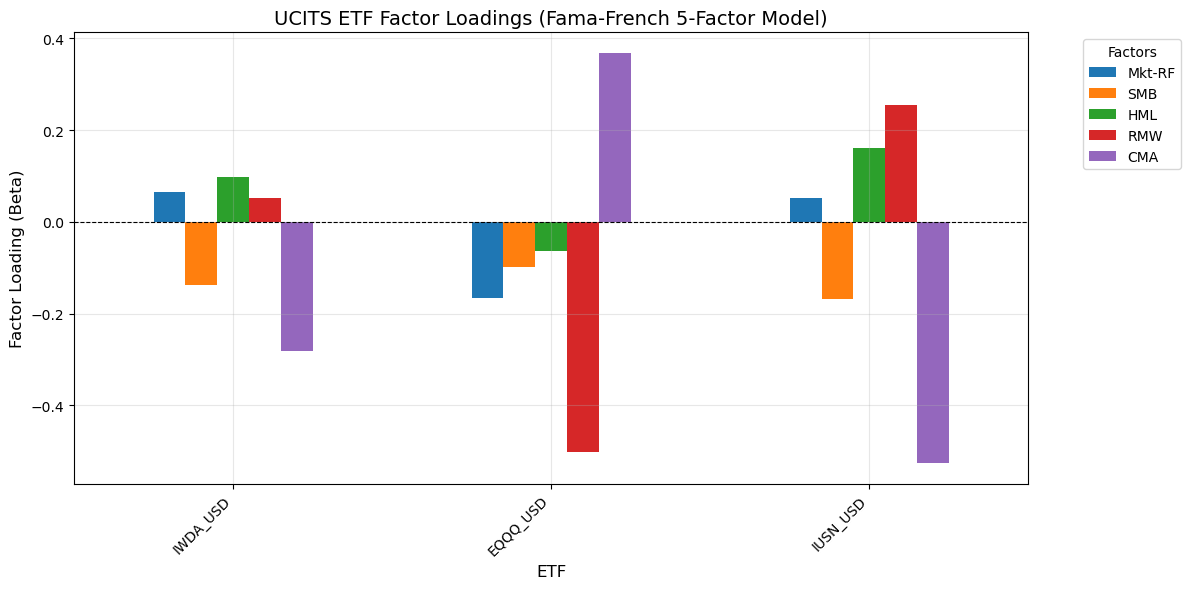


Factor Loadings Summary:
            Mkt-RF       SMB       HML       RMW       CMA
IWDA_USD  0.065984 -0.137395  0.098291  0.051397 -0.281240
EQQQ_USD -0.165187 -0.098119 -0.063639 -0.502884  0.368516
IUSN_USD  0.051458 -0.168522  0.161264  0.255422 -0.526030


In [114]:
# Visualize factor loadings across UCITS ETFs
loadings_dict = {}

for etf in ucits_monthly_returns.columns:
    y = ucits_combined[etf] - ucits_combined['RF']
    X = sm.add_constant(ucits_combined[factor_cols])
    model = sm.OLS(y, X).fit()
    loadings_dict[etf] = model.params[factor_cols]

# Create DataFrame of loadings
loadings_df = pd.DataFrame(loadings_dict).T

# Plot factor loadings
fig, ax = plt.subplots(figsize=(12, 6))
loadings_df.plot(kind='bar', ax=ax)
ax.set_title('UCITS ETF Factor Loadings (Fama-French 5-Factor Model)', fontsize=14)
ax.set_xlabel('ETF', fontsize=12)
ax.set_ylabel('Factor Loading (Beta)', fontsize=12)
ax.legend(title='Factors', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nFactor Loadings Summary:")
print(loadings_df)